In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/userdata/jgauthier/projects/ideal-word-representations


In [3]:
from collections import defaultdict, Counter

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
import re
import torch
from typing import Union, Callable
from tqdm.auto import tqdm

from src.utils import concat_csv_with_indices

In [4]:
state_space_spec_path = "outputs/state_space_specs/librispeech-train-clean-100/w2v2_8/state_space_specs.pkl"



In [5]:
predictions_df = concat_csv_with_indices("outputs/word_recognition/librispeech-train-clean-100/**/predictions-frame_*.csv",
                        [re.compile(r"frame_(\d+)\.csv"),
                         lambda p: p.parents[2].name,
                         lambda p: p.parents[3].name, lambda p: p.parents[4].name,
                         lambda p: p.parents[5].name],
                        ["frame_idx",
                         "equivalence", "model", "base_model", "dataset"
                          ]).reset_index()

predictions_df["frame_idx"] = predictions_df.frame_idx.astype(int)

predictions_df["trace"] = predictions_df.base_model + "/" + predictions_df.model + "/" + predictions_df.equivalence

In [6]:
# estimate chance performance for word recognition at each dataset + frame
chance_performance = {}
for dataset, dataset_results in predictions_df.groupby("dataset"):
    # take any trace; they're all the same
    chance_df = next(iter(dataset_results.groupby("trace")))[1]
    # # words should all be balanced in this evaluaton, so we can take the mean of relative word frequency
    # words may not be balanced; take the max-probability word assuming random guessing
    chance_performance[dataset] = chance_df.groupby("frame_idx").apply(lambda x: x.label.value_counts(normalize=True).max()).rename("chance_performance")
chance_performance = pd.concat(chance_performance, names=["dataset"])
chance_performance

/tmp/ipykernel_2020164/1779887723.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  chance_performance[dataset] = chance_df.groupby("frame_idx").apply(lambda x: x.label.value_counts(normalize=True).max()).rename("chance_performance")


dataset                      frame_idx
librispeech-train-clean-100  0            0.000195
                             1            0.000195
                             2            0.000201
                             3            0.000235
                             4            0.000305
                             5            0.000441
                             6            0.000697
                             7            0.001190
                             8            0.002205
                             9            0.004537
                             10           0.009673
                             11           0.024190
                             12           0.068027
                             13           0.127273
                             14           0.346154
                             15           0.666667
Name: chance_performance, dtype: float64

In [9]:
plot_dataset = "librispeech-train-clean-100"
study_model = "w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames"

# ax = sns.lineplot(data=df[df.dataset == plot_dataset], x="num_frames", y="mAP", hue="trace")
# ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
# ax.set_xlabel("# phonemes seen")

# # draw chance performance as a horizontal line over each x value
# for frame, frame_chance_perf in chance_performance.loc[plot_dataset].items():
#     ax.plot([frame + 1, frame + 2], [frame_chance_perf, frame_chance_perf],
#             color="gray", linestyle="--")

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

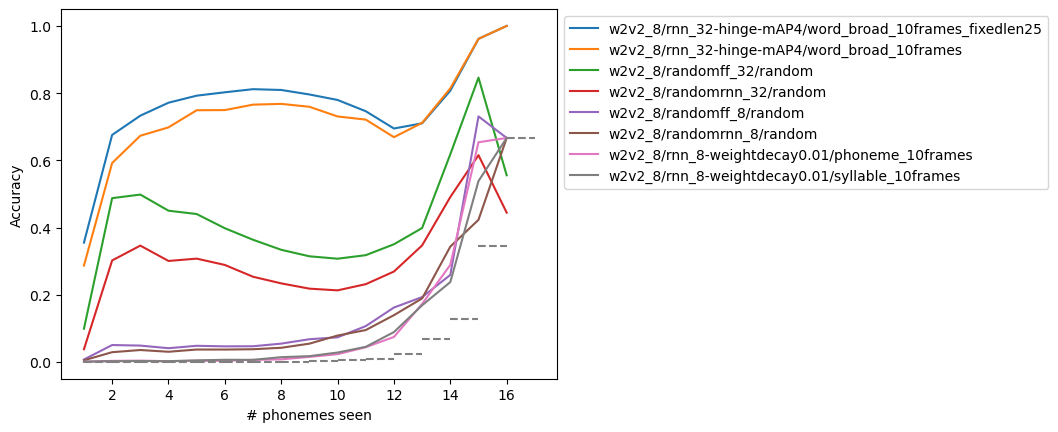

In [24]:
acc_df = predictions_df.loc[(predictions_df.dataset == plot_dataset) & (~predictions_df.trace.str.contains("hinge_ph"))] \
    .groupby(["trace", "frame_idx"]).correct.mean().reset_index()
acc_df["num_frames"] = acc_df.frame_idx + 1
hue_order = acc_df.groupby("trace").correct.mean().sort_values(ascending=False).index
ax = sns.lineplot(data=acc_df,
                  x="num_frames", y="correct", hue="trace", hue_order=hue_order)

ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("# phonemes seen")
ax.set_ylabel("Accuracy")

# draw chance performance as a horizontal line over each x value
for frame, frame_chance_perf in chance_performance.loc[plot_dataset].items():
    ax.plot([frame + 1, frame + 2], [frame_chance_perf, frame_chance_perf],
            color="gray", linestyle="--")

## Frequency effects in recognition

In [10]:
word_freq_df = pd.read_csv("data/SUBTLEXus74286wordstextversion.txt", sep="\t", index_col=0)

In [11]:
num_frequency_bins = 6
word_freq_df["log_frequency_bin"] = pd.qcut(word_freq_df.Lg10WF, num_frequency_bins, labels=list(range(num_frequency_bins - 1)), duplicates="drop").astype(int)

In [12]:
predictions_df_meta = pd.merge(predictions_df, word_freq_df, left_on="label", right_index=True)

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

<Axes: xlabel='frame_idx', ylabel='correct'>

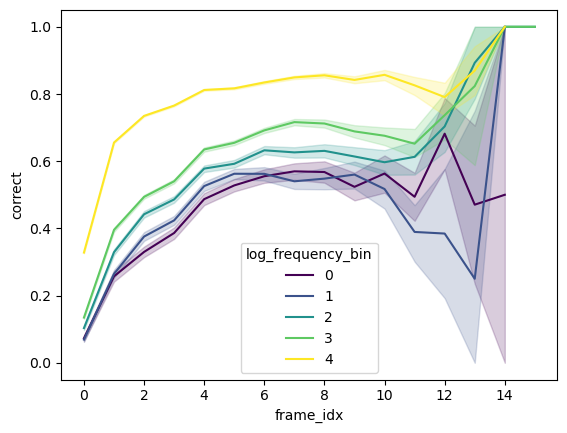

In [13]:
sns.lineplot(data=predictions_df_meta[predictions_df_meta.trace == study_model],
             x="frame_idx", y="correct", hue="log_frequency_bin", palette="viridis")

## Accuracy distribution between words

In [26]:
accuracy_distribution_df = predictions_df_meta \
    .groupby(["trace", "label", "label_instance_idx", "Lg10WF", "log_frequency_bin"]).correct.max() \
    .groupby(["trace", "label", "Lg10WF", "log_frequency_bin"]).filter(lambda x: len(x) >= 20) \
    .groupby(["trace", "label", "Lg10WF", "log_frequency_bin"]).mean()
accuracy_distribution_df

trace                                           label       Lg10WF  log_frequency_bin
w2v2_8/randomff_32/random                       a           6.0175  4                    0.08
                                                ability     2.9917  4                    1.00
                                                able        3.9115  4                    1.00
                                                aboard      3.1332  4                    0.95
                                                about       5.2677  4                    0.94
                                                                                         ... 
w2v2_8/rnn_8-weightdecay0.01/syllable_10frames  your        5.5168  4                    0.00
                                                yours       4.0188  4                    0.00
                                                yourself    4.3454  4                    0.00
                                                yourselves  3.1703  

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

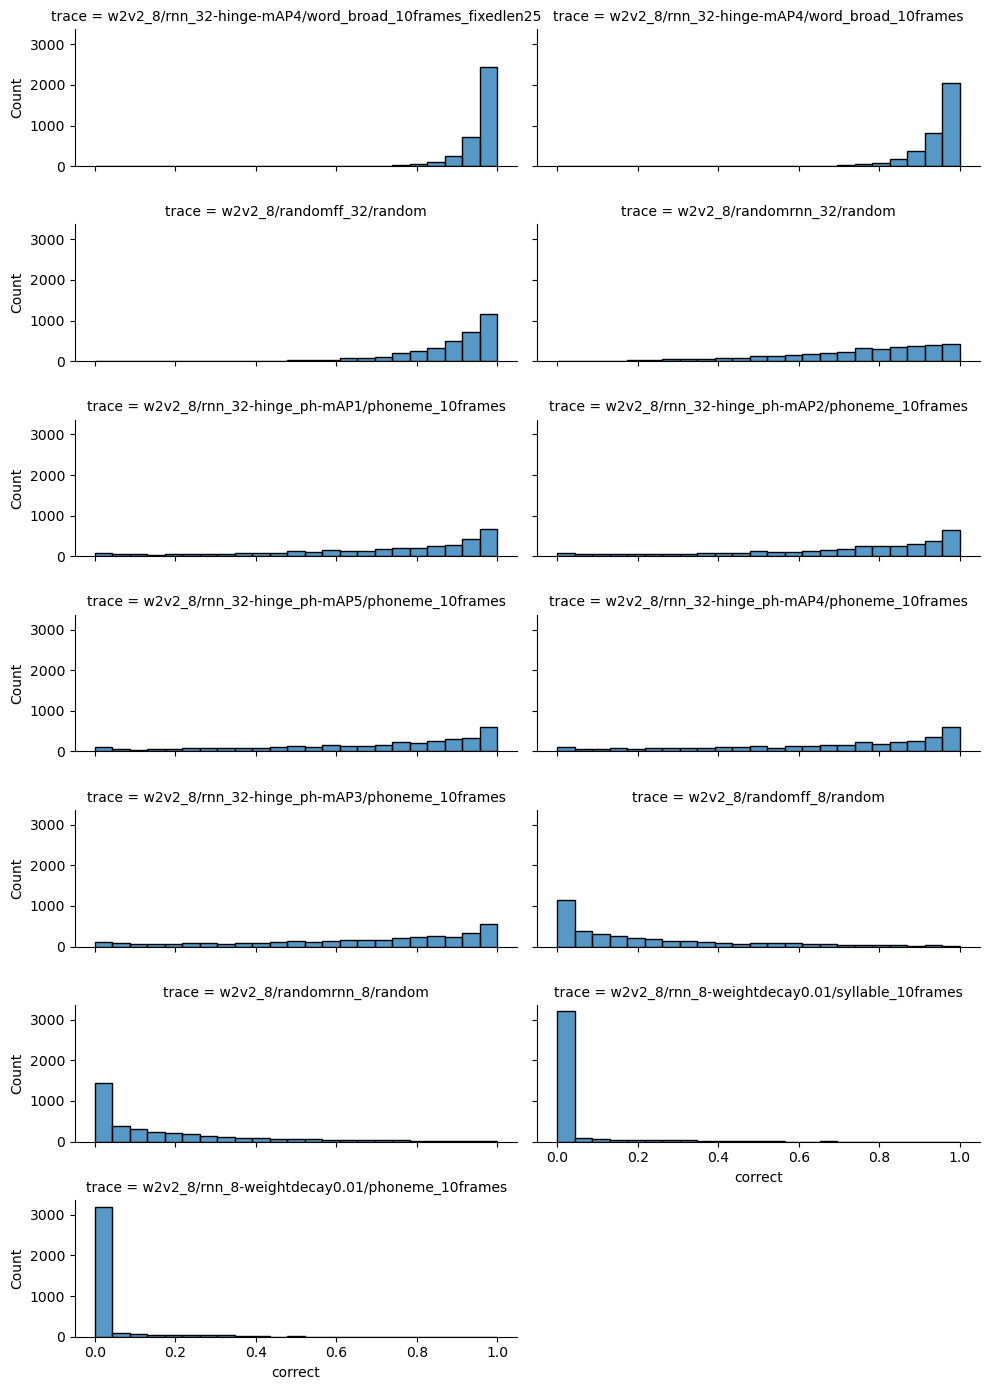

In [31]:
col_order = accuracy_distribution_df.groupby("trace").mean().sort_values(ascending=False).index
sns.displot(data=accuracy_distribution_df.reset_index(), 
            x="correct", col="trace", col_order=col_order, col_wrap=2, height=2, aspect=2.5)

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

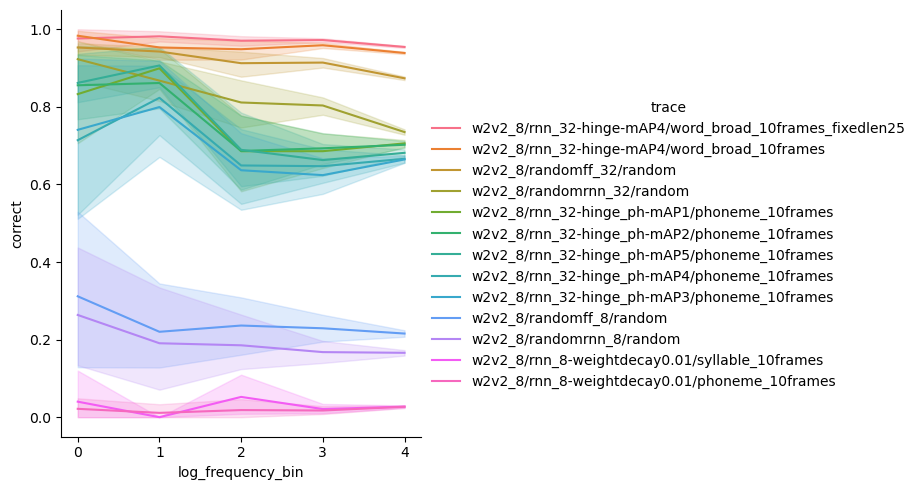

In [37]:
sns.relplot(data=accuracy_distribution_df.reset_index(),
            x="log_frequency_bin", y="correct", hue="trace", hue_order=accuracy_distribution_df.groupby("trace").mean().sort_values(ascending=False).index, kind="line")

## Cohort effects in recognition

In [49]:
# We don't save the actual training set which is a subsample of the full state space spec.
# We thus won't be able to get item-level stats on cohort of a particular word pronunciation.
# But we can get the expected / marginal case.

In [ ]:
# state_space_spec.subsample_instances(100).cuts.xs("phoneme", level="level").to_csv("librispeech-phonemes.csv")

In [9]:
# # dev_df = state_space_spec.subsample_instances(100).cuts.xs("phoneme", level="level")
# dev_df = pd.read_csv("librispeech-phonemes.csv", index_col=[0, 1])

In [36]:
dev_df = state_space_spec.cuts.xs("phoneme", level="level")
dev_df["phoneme_idx"] = dev_df.groupby(["label", "instance_idx"]).cumcount()

/tmp/ipykernel_1067678/2882130717.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df["phoneme_idx"] = dev_df.groupby(["label", "instance_idx"]).cumcount()


In [37]:
import duckdb
# do the same thing with duckdb on the dev_df
dev_df_dev = duckdb.from_df(dev_df.reset_index())

# reset temporary tables
duckdb.query("DROP TABLE IF EXISTS phoneme_sequences; DROP TABLE IF EXISTS cohorts;")

# get a table of cohort sizes
cohorts = duckdb.query("""
    -- Step 1: Create a temporary table with concatenated descriptions and their lengths
    CREATE TEMPORARY TABLE phoneme_sequences AS
    SELECT 
        label, 
        instance_idx, 
        STRING_AGG(description, ' ' ORDER BY phoneme_idx) AS phoneme_seq,
        LENGTH(STRING_AGG(description, ' ')) - LENGTH(REPLACE(STRING_AGG(description, ' '), ' ', '')) + 1 AS phoneme_count
    FROM dev_df_dev
    GROUP BY label, instance_idx;

    -- Step 2: Create cohorts table
    CREATE TEMPORARY TABLE cohorts AS
    WITH recursive cohorts_cte AS (
        SELECT 
            label,
            instance_idx,
            phoneme_seq,
            SPLIT_PART(phoneme_seq, ' ', 1) AS prefix,
            phoneme_count,
            1 AS prefix_length
        FROM phoneme_sequences
        UNION ALL
        SELECT 
            label,
            instance_idx,
            phoneme_seq,
            TRIM(prefix || ' ' || REGEXP_EXTRACT(SUBSTRING(phoneme_seq FROM LENGTH(prefix) + 2), '^[^ ]+')) AS prefix,
            phoneme_count,
            prefix_length + 1
        FROM cohorts_cte
        WHERE prefix_length < phoneme_count
    )
    SELECT 
        prefix AS phoneme_prefix,
        label,
        COUNT(*) AS count
    FROM cohorts_cte
    GROUP BY phoneme_prefix, label;
             
    SELECT * FROM cohorts;
    """).to_df().set_index(["phoneme_prefix", "label"]).sort_index()

In [38]:
cohorts

count
phoneme_prefix     label           
AA                 abbaye         1
                   accursed       2
                   agostino       1
                   ah           178
                   aha            3
...                             ...
ZH AA N D AA R M   gendarme       1
                   gendarmes      2
ZH AA N D AA R M Z gendarmes      2
ZH AA N R          genre          1
ZH AA N R AH       genre          1

[214721 rows x 1 columns]

,label,phoneme_seq,proportion
0,ablest,EY B L AH S T,1.0
1,absolutely,AE B S AH L UW T L IY,1.0
2,abysmal,AH B IH Z M AH L,1.0
3,abyss,AH B IH S,1.0
4,accentuation,AE K S EH N CH AH W EY SH AH N,1.0
...,...,...,...
34197,yon,Y AA N,1.0
34198,york,Y AO R K,1.0
34199,yoshida,Y OW SH IY D AH,1.0
34200,zeus's,Z EY AH S IH Z,1.0


In [40]:
prefix2idx = {prefix: idx for idx, prefix in enumerate(sorted(cohorts.index.get_level_values("phoneme_prefix").unique()))}
idx2prefix = {idx: prefix for prefix, idx in prefix2idx.items()}
idx2word = sorted(articulation_df.label.unique())
word2idx = {word: idx for idx, word in enumerate(idx2word)}

import scipy.sparse as sp
prefix_mat = sp.dok_matrix((len(word2idx), len(prefix2idx)))

for _, row in articulation_df.iterrows():
    phoneme_seq = row.phoneme_seq.split(" ")
    for prefix_length in range(1, len(phoneme_seq) + 1):
        prefix_mat[word2idx[row.label], prefix2idx[" ".join(phoneme_seq[:prefix_length])]] += row.proportion

prefix_mat = prefix_mat.tocsr()

In [41]:
cohort_sizes = prefix_mat.sum(axis=0).A1
cohort_entropies = -(prefix_mat / prefix_mat.sum(axis=0)).multiply((prefix_mat / prefix_mat.sum(axis=0)).log1p()).sum(axis=0).A1
cohort_entropies[np.isnan(cohort_entropies)] = 0

In [42]:
cohort_sizes

array([364.84753953,  30.91832319,   2.        , ...,   1.        ,
         1.        ,   1.        ])

In [43]:
[idx2prefix[idx] for idx in (-cohort_sizes).argsort()[:5]]

['S', 'K', 'P', 'D', 'B']

In [44]:
# construct masks for each frame idx
frame_idx_masks = np.stack([np.array([1 if prefix.count(" ") == frame_idx else 0 for prefix in idx2prefix.values()]) for frame_idx in range(10)]).T
frame_idx_masks.shape

(74698, 10)

In [45]:
incremental_cohort_sizes = prefix_mat.multiply(cohort_sizes).dot(frame_idx_masks)
incremental_cohort_entropies = prefix_mat.multiply(cohort_entropies).dot(frame_idx_masks)

In [46]:
articulation_df["num_phonemes"] = articulation_df.phoneme_seq.str.count(" ") + 1
word_max_lengths = articulation_df.groupby("label").num_phonemes.max()

# Create a mask on the derived cohort stats for phonemes never attested
attested_mask = np.zeros_like(incremental_cohort_sizes, dtype=bool)
for word, max_length in word_max_lengths.items():
    attested_mask[word2idx[word], max_length:] = True

incremental_cohort_sizes[attested_mask] = np.nan
incremental_cohort_entropies[attested_mask] = np.nan

In [51]:
cohort_size_df = pd.DataFrame(incremental_cohort_sizes, index=pd.Index(idx2word, name="label")).reset_index().melt(id_vars=["label"], var_name="frame_idx", value_name="cohort_size")
cohort_entropy_df = pd.DataFrame(incremental_cohort_entropies, index=pd.Index(idx2word, name="label")).reset_index().melt(id_vars=["label"], var_name="frame_idx", value_name="cohort_entropy")
cohort_meta_df = pd.merge(cohort_size_df, cohort_entropy_df)
cohort_meta_df = cohort_meta_df.dropna()

cohort_meta_df["cohort_size_bin"] = pd.qcut(cohort_meta_df.cohort_size, 8, duplicates="drop")
cohort_meta_df["cohort_size_bin"] = cohort_meta_df.cohort_size_bin.cat.codes
cohort_meta_df["cohort_entropy_bin"] = pd.qcut(cohort_meta_df.cohort_entropy, 8, duplicates="drop")
cohort_meta_df["cohort_entropy_bin"] = cohort_meta_df.cohort_entropy_bin.cat.codes
cohort_meta_df

,label,frame_idx,cohort_size,cohort_entropy,cohort_size_bin,cohort_entropy_bin
0,a,0,1526.208871,-0.001388,7,6
1,a'rony,0,96.986262,-0.010171,5,5
2,aaron,0,679.401557,-0.001459,6,6
3,aback,0,1654.134883,-0.000602,7,7
4,abaft,0,1654.134883,-0.000602,7,7
...,...,...,...,...,...,...
321757,withstanding,9,1.000000,-0.693147,0,0
321768,wittgenstein,9,1.000000,-0.693147,0,0
321769,witticisms,9,1.000000,-0.693147,0,0
321793,womanliness,9,1.000000,-0.693147,0,0


In [52]:
predictions_df_meta = pd.merge(predictions_df, cohort_meta_df, on=["label", "frame_idx"], how="left")

In [55]:
predictions_df_meta.trace.value_counts()

trace
w2v2_8/rnn_8-weightdecay0.01/syllable_10frames             1408180
w2v2_8/randomff_32/random                                  1408180
w2v2_8/randomrnn_32/random                                 1408150
w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames_fixedlen25    1408140
w2v2_8/randomrnn_8/random                                  1408135
w2v2_8/randomff_8/random                                   1408132
w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames               1408118
w2v2_8/rnn_8-weightdecay0.01/phoneme_10frames              1408104
Name: count, dtype: int64

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

<Axes: xlabel='frame_idx', ylabel='correct'>

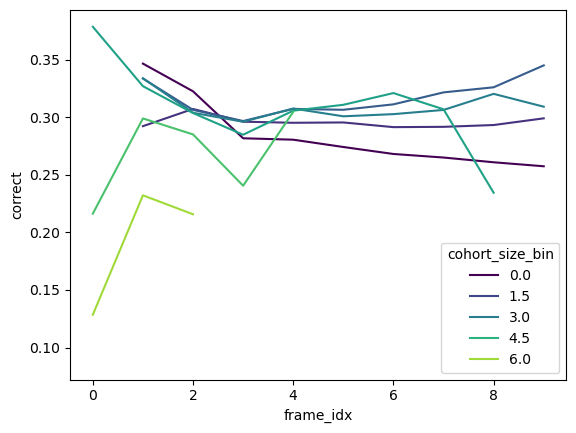

In [53]:
sns.lineplot(data=predictions_df_meta, x="frame_idx", y="correct", hue="cohort_size_bin", palette="viridis", errorbar=None)

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

<Axes: xlabel='frame_idx', ylabel='correct'>

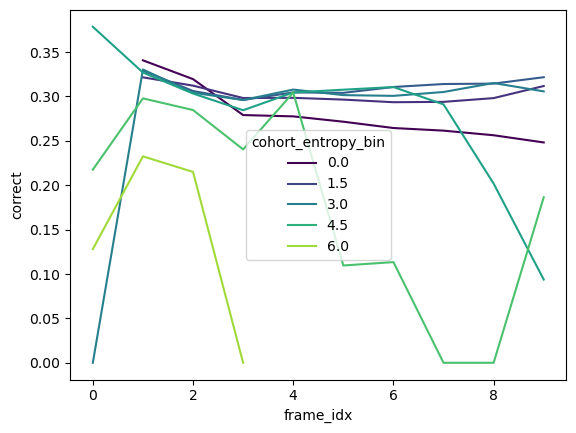

In [54]:
sns.lineplot(data=predictions_df_meta, x="frame_idx", y="correct", hue="cohort_entropy_bin", palette="viridis", errorbar=None)

In [88]:
sns.catplot(data=predictions_df_meta, x="cohort_size_bin", y="correct", kind="swarm")

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


KeyboardInterrupt: 

## Neighborhood density

In [84]:
aelp_df = pd.read_csv("data/aelp.csv", index_col=0)

aelp_df["phono_dens_bin"] = pd.qcut(aelp_df.phono_n_dens_s, 5, duplicates="drop")
print(aelp_df.phono_dens_bin.cat.categories)
aelp_df["phono_dens_bin"] = aelp_df.phono_dens_bin.cat.codes
aelp_df

IntervalIndex([(0.999, 2.0], (2.0, 5.0], (5.0, 11.0], (11.0, 35.0]], dtype='interval[float64, right]')


,word_length,ortho_n_dens_s,ortho_n_freq_s_m,ortho_n_freq_s_sd,ortho_upoint,old20_m,old20_sd,sum_bigram,n_phon,n_syll,...,f3_ldt_rt_sd,f3_ldt_rt_n,us_ldt_rt_m,us_ldt_rt_sd,us_ldt_rt_n,uk_ldt_rt_m,uk_ldt_rt_sd,uk_ldt_rt_n,Unnamed: 42,phono_dens_bin
word_us,,,,,,,,,,,,,,,,,,,,,
abide,5,3,1.538447,1.541942,5,1.75,0.444262,0.016870,4,2,...,248.713638,26.0,877.015385,152.772450,65.0,936.462963,235.064801,54.0,NaN,1
ability,7,1,1.380211,NaN,4,2.35,0.587143,0.036109,7,4,...,227.004801,27.0,860.171875,206.685833,64.0,801.800000,218.271611,55.0,NaN,0
aboard,6,0,NaN,NaN,4,2.35,0.587143,0.017578,5,2,...,265.293881,25.0,1029.591837,273.620549,49.0,1008.304348,232.121890,46.0,NaN,1
abortion,8,0,NaN,NaN,9,2.65,0.489360,0.066180,7,3,...,163.303253,28.0,886.238806,172.297320,67.0,854.636364,161.295147,55.0,NaN,0
abound,6,1,4.574887,NaN,7,1.90,0.307794,0.018515,5,2,...,210.679016,21.0,1073.477273,232.257925,44.0,1037.086957,245.492777,46.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zip,3,10,2.507738,0.443559,4,1.50,0.512989,0.002779,3,1,...,216.017654,25.0,828.578125,155.315021,64.0,880.120000,212.985737,50.0,NaN,3
zipper,6,2,1.537773,0.008902,5,1.90,0.307794,0.058730,5,2,...,166.761953,24.0,879.218750,147.904352,64.0,850.519231,168.140638,52.0,NaN,1
zone,4,8,3.071161,0.992732,5,1.45,0.510418,0.033249,3,1,...,219.444466,23.0,936.698113,238.505732,53.0,987.875000,195.566675,48.0,NaN,2


In [85]:
aelp_df_merged = pd.merge(predictions_df_meta, aelp_df, left_on="label", right_index=True)

In [86]:
aelp_df_merged.groupby("phono_dens_bin").sample(5)[["label", "phono_dens_bin", "phono_n_dens_s"]]

,label,phono_dens_bin,phono_n_dens_s
4056496,outside,0,2
3033347,spinal,0,1
3232190,music,0,2
1185680,meantime,0,1
497453,protection,0,1
3352054,stream,1,4
1913194,brand,1,3
5029809,lower,1,5
212808,slept,1,3
5305335,former,1,4


/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

<Axes: xlabel='frame_idx', ylabel='correct'>

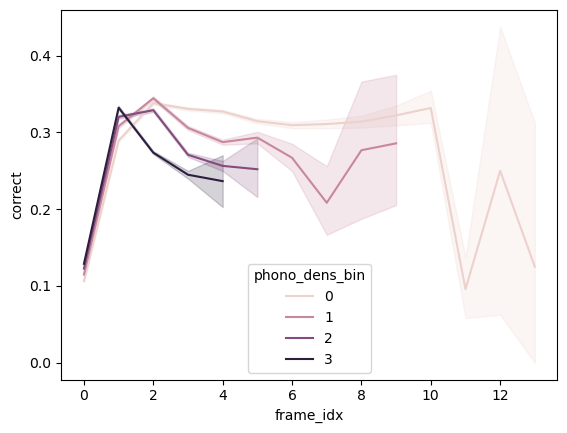

In [87]:
sns.lineplot(data=aelp_df_merged, x="frame_idx", y="correct", hue="phono_dens_bin")